# Capturing greenhouse gases with data

## Exploratory Data Analysis

### by Zachary Brown

In the ARC-MOF data wrangling notebook I combined five datasets on hypothetical MOF properties and then reduced it to only entries focused on post-combustion vacuum swing adsorption (VSA). Now in this notebook I will explore the data to look for correlations that may help drive model development, and to gain a better understanding for myself as to which features help improve CO2 uptake.

First I'll install any new libraries needed that weren't included in the previous notebook. I'll then import the necessary libraries.

In [1]:
!pip install seaborn==0.12.2
!pip install statsmodels==0.13.5
!pip install scipy==1.10.1
!pip install tqdm==4.64.1

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm 
from statsmodels.graphics.api import abline_plot
import scipy.stats
from tqdm import tqdm

In [4]:
data = pd.read_csv('../data/interim/wrangled.csv')

In [4]:
data.head()

,filename,unit_cell_volume,Density,accessible_surface_area,volumetric_surface_area,gravimetric_surface_area,inaccessible_surface_area,inac_grav_surf_area,inac_vol_surf_area,accessible_volume_per_uc,...,D_func-alpha-2-all,D_func-alpha-3-all,order_f-lig,bool_f-lig,order_mc,bool_mc,order_func,bool_func,order_lc,bool_lc
0,DB0-m2_o1_o10_f0_pcu.sym.66.cif,901.788,1.233220,87.4832,970.108,786.644,0.000000,0.000000,0.000000,26.0256,...,41.885780,23.764297,43831,True,18963,True,21096,True,4072,True
1,DB0-m3_o23_o23_f0_pcu.sym.74.cif,7545.840,0.537679,1566.3300,2075.750,3860.570,0.000000,0.000000,0.000000,2364.4100,...,4.400000,17.857187,100001,False,44145,True,100001,False,42138,True
2,DB0-m2_o8_o25_f0_pcu.sym.91.cif,4172.230,0.371648,771.9300,1850.160,4978.270,0.000000,0.000000,0.000000,2102.0500,...,-7.433333,-5.745183,100001,False,100001,False,100001,False,100001,False
3,DB0-m29_o82_o46_f0_pts.sym.1.cif,1715.110,0.786327,378.9050,2209.230,2809.550,0.000000,0.000000,0.000000,281.5860,...,-6.000000,-12.000000,100001,False,100001,False,100001,False,100001,False
4,DB0-m29_o99_o470_f0_pts.sym.128.cif,2552.970,0.754924,419.5890,1643.530,2177.080,0.164038,0.642539,0.851131,268.4700,...,-10.339258,-17.664703,100001,False,100001,False,84717,True,100001,False


In [5]:
print(data.columns.tolist())

['filename', 'unit_cell_volume', 'Density', 'accessible_surface_area', 'volumetric_surface_area', 'gravimetric_surface_area', 'inaccessible_surface_area', 'inac_grav_surf_area', 'inac_vol_surf_area', 'accessible_volume_per_uc', 'volume_fraction', 'grav_volume', 'inac_vol', 'inac_vol_frac', 'inac_grav_vol', 'probe_occupiable_vol', 'probe_occ_vol_frac', 'grav_probe_occ_vol', 'inac_probe_occ_vol', 'inac_probe_occ_vol_frac', 'inac_probe_occ_grav_vol', 'largest_cav_diameter', 'pore_limiting_diameter', 'largest_free_sphere_path_diam', 'order_geo', 'bool_geo', 'Crystalnet', 'likely topology', 'RDF_electronegativity_2.000', 'RDF_electronegativity_2.004', 'RDF_electronegativity_2.013', 'RDF_electronegativity_2.027', 'RDF_electronegativity_2.044', 'RDF_electronegativity_2.066', 'RDF_electronegativity_2.093', 'RDF_electronegativity_2.124', 'RDF_electronegativity_2.159', 'RDF_electronegativity_2.199', 'RDF_electronegativity_2.243', 'RDF_electronegativity_2.292', 'RDF_electronegativity_2.345', 'RDF

I need to select a specific feature as my target for this project. CO2 capture can be measured in many ways: mmol of CO2 adsorbed per gram of material, volume of CO2 adsorbed per volume of material, or the weight of CO2 adsorbed by some mass of material. An important caveat that needs to be considered is that in this process, the material is saturated with CO2, and then it has to be regenerated via a vacuum process. That regeneration may not be 100% perfect, meaning that in a real life process, the 'working capacity' is lower than the absolute measurements. Given these considerations I'll focus on the 'v/v_working_capacity' column as my target, because theoretically we would want smaller filters to catch as much CO2 as possible, rather than focusing on weight. 

With that being said, I'll start out by plotting the distribution of volumetric working capacity to get a feel for the spread we're working with.

In [5]:
sns.set_theme('notebook')

In [6]:
from matplotlib import rcParams
rcParams['mathtext.default'] = 'regular'

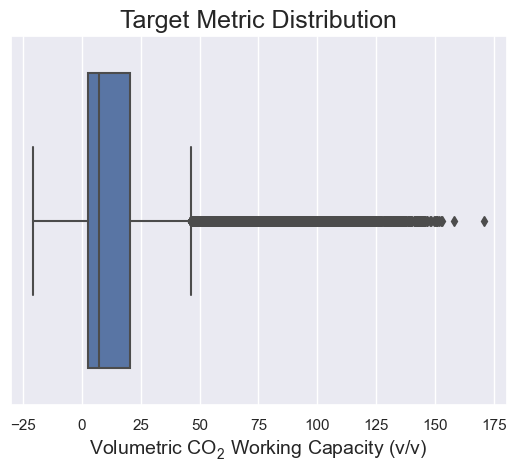

In [8]:
sns.boxplot(data = data, x = 'v/v_working_capacity')
plt.xlabel('Volumetric $CO_2$ Working Capacity (v/v)', fontsize = 14)
plt.title('Target Metric Distribution', fontsize = 18)
plt.savefig('../figures/vol_work_capac_dist.png',dpi=1200, bbox_inches='tight')
plt.show()

Now I'll plot unit cell volume, density, accessible, volumetric, and gravimetric surface areas, largest cavity diameter, and pore limiting diameter against my target to see if these show any correlation.

In [7]:
data.drop(columns=['Unnamed: 0'], inplace=True)
data = data.dropna(subset='v/v_working_capacity')
data.shape

(255938, 900)

In [12]:
# Graphing an OLS correlation between a named feature and CO2 working capacity
def correlate(feature, x_label, title):
    adj_data = data.dropna(subset=feature)
    
    # Set the variables for the OLS model
    dependent = adj_data[['v/v_working_capacity']]
    independent = sm.add_constant(adj_data[[feature]])
    
    # Create the OLS model, fit it, and pull out the slope and intercept
    model = sm.OLS(dependent, independent)
    fit = model.fit()
    b, m = fit.params
    
    # Create the points for the OLS trendline
    x = np.array([0, np.max(adj_data[feature])])
    y = (m*x)+b
    
    # Plot the data with the OLS trendline overlay
    sns.scatterplot(data=adj_data, x=feature, y='v/v_working_capacity', alpha=0.1, color='blue')
    plt.plot(x, y, color='red')
    plt.title(title, fontsize = 18)
    plt.xlabel(x_label, fontsize = 14)
    plt.ylabel(r'Volumetric Working $CO_{2}$ Capacity $(cm^{3}/cm^{-3})$', fontsize = 14)
    plt.text(0.75*max(adj_data[feature]), 0.75*max(adj_data['v/v_working_capacity']), 
             'Slope: ' + str(round(fit.params[1], 4)), fontsize = 14)
    plt.savefig('../figures/capacity_vs_'+feature+'.png',dpi=1200, bbox_inches='tight')
    plt.show()

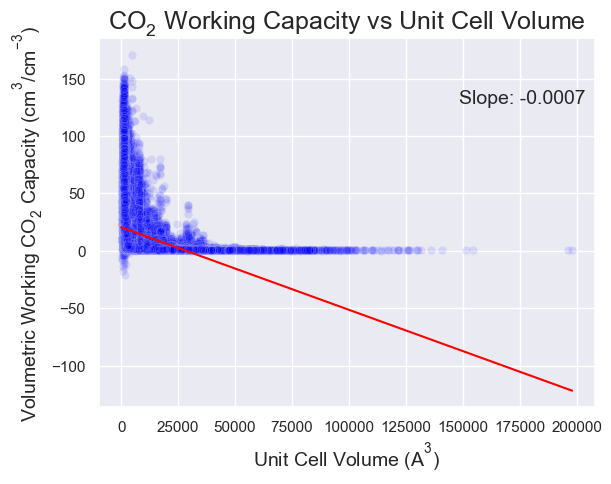

In [11]:
correlate('unit_cell_volume', r'Unit Cell Volume $(A^{3})$', r'$CO_{2}$ Working Capacity vs Unit Cell Volume')

In [8]:
data['ucv_log'] = np.log(data['unit_cell_volume'])

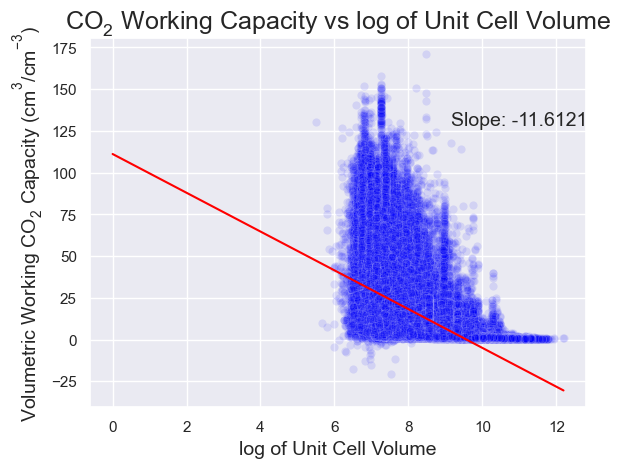

In [13]:
correlate('ucv_log', 'log of Unit Cell Volume', r'$CO_{2}$ Working Capacity vs log of Unit Cell Volume')

In [13]:
import math
no_na = data.dropna(subset='unit_cell_volume').reset_index()

In [14]:
asinh_ucv = []
for i in range(len(no_na['unit_cell_volume'])): 
    asinh_ucv.append(math.asinh(no_na['unit_cell_volume'][i])) 
    i += 1

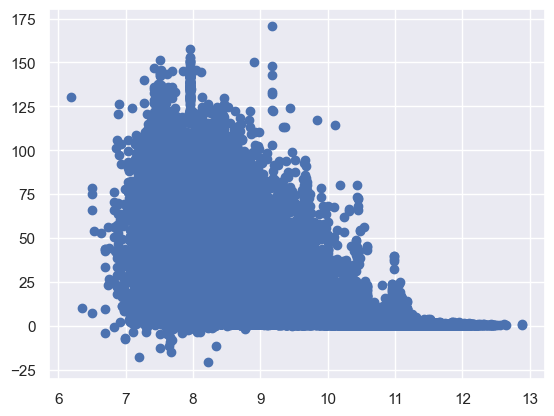

In [15]:
plt.plot(asinh_ucv, no_na['v/v_working_capacity'], marker='o', linestyle='')
plt.show()

In [16]:
acosh_ucv = []
for i in range(len(no_na['unit_cell_volume'])): 
    acosh_ucv.append(math.acosh(no_na['unit_cell_volume'][i])) 
    i += 1

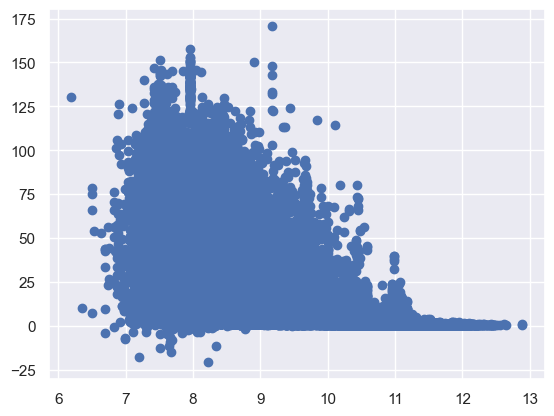

In [17]:
plt.plot(acosh_ucv, no_na['v/v_working_capacity'], marker='o', linestyle='')
plt.show()

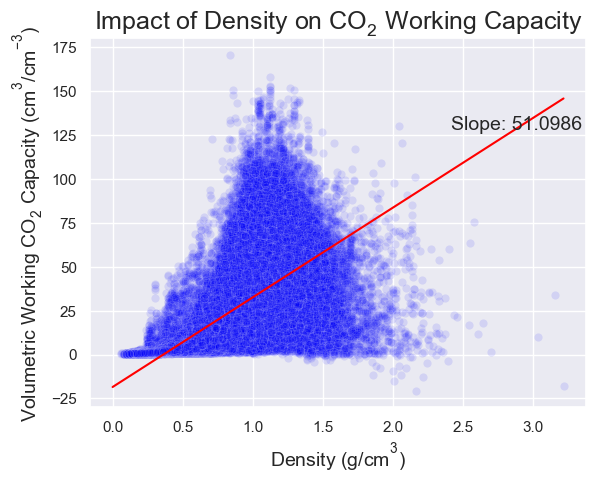

In [19]:
correlate('Density', r'Density $(g/cm^3)$', 'Impact of Density on $CO_2$ Working Capacity')

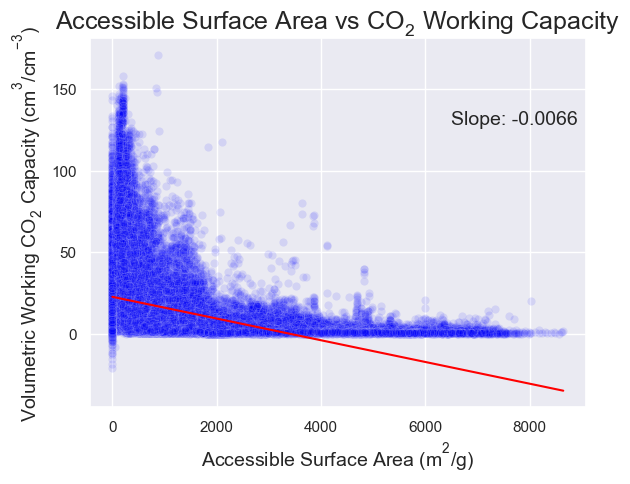

In [20]:
correlate('accessible_surface_area', 'Accessible Surface Area $(m^2/g)$', 'Accessible Surface Area vs $CO_2$ Working Capacity')

In [17]:
asa_nz = data[data['accessible_surface_area'] != 0]
data['asa_log'] = np.log(asa_nz['accessible_surface_area'])

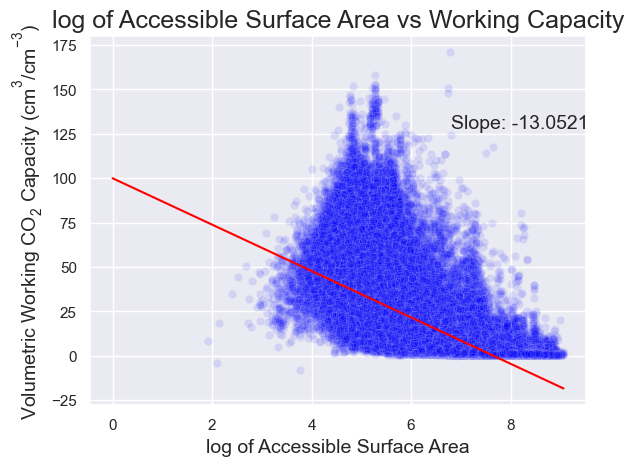

In [24]:
correlate('asa_log', 'log of Accessible Surface Area', 'log of Accessible Surface Area vs Working Capacity')

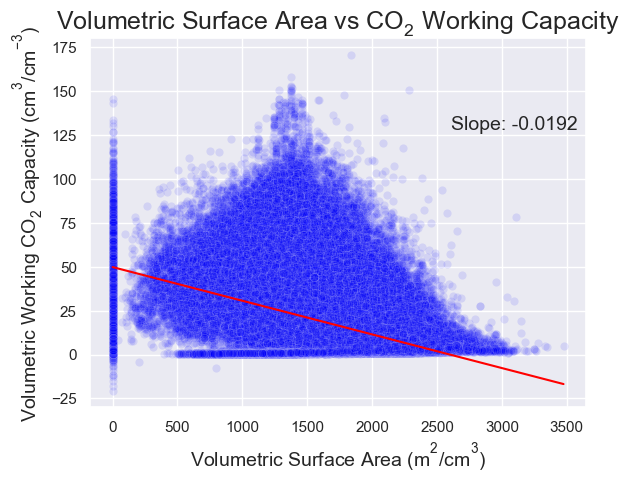

In [21]:
correlate('volumetric_surface_area', 'Volumetric Surface Area $(m^2/cm^3)$', 'Volumetric Surface Area vs $CO_2$ Working Capacity')

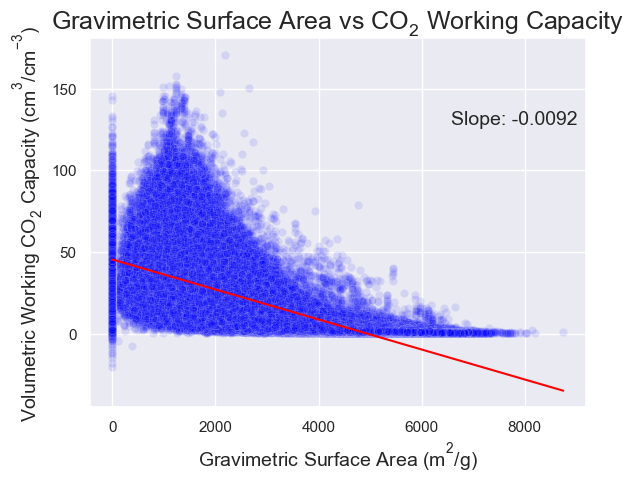

In [22]:
correlate('gravimetric_surface_area', 'Gravimetric Surface Area $(m^2/g)$', 'Gravimetric Surface Area vs $CO_2$ Working Capacity')

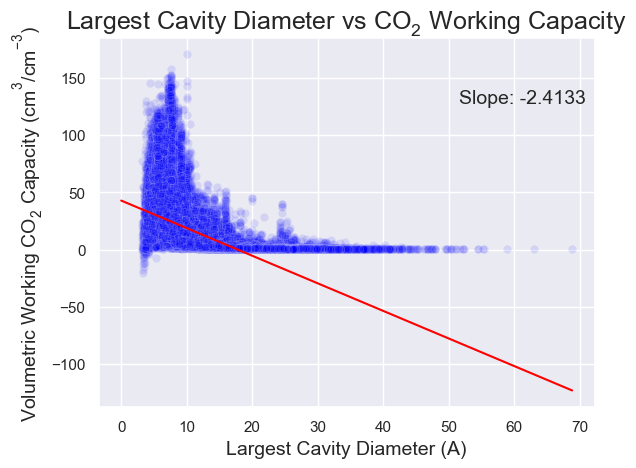

In [23]:
correlate('largest_cav_diameter', 'Largest Cavity Diameter (A)', 'Largest Cavity Diameter vs $CO_2$ Working Capacity')

In [19]:
data['lcd_log'] = np.log(data['largest_cav_diameter'])

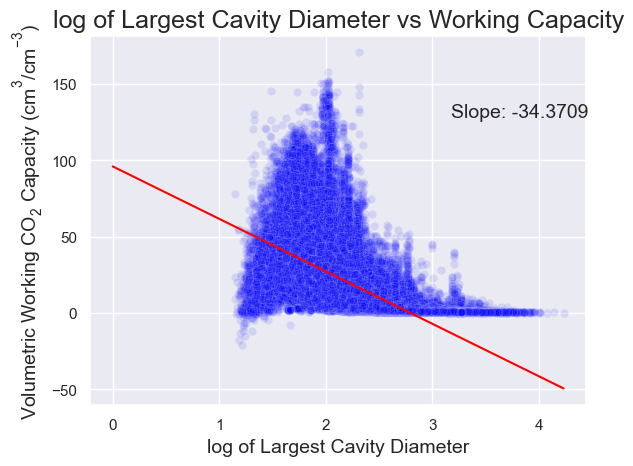

In [22]:
correlate('lcd_log', 'log of Largest Cavity Diameter', 'log of Largest Cavity Diameter vs Working Capacity')

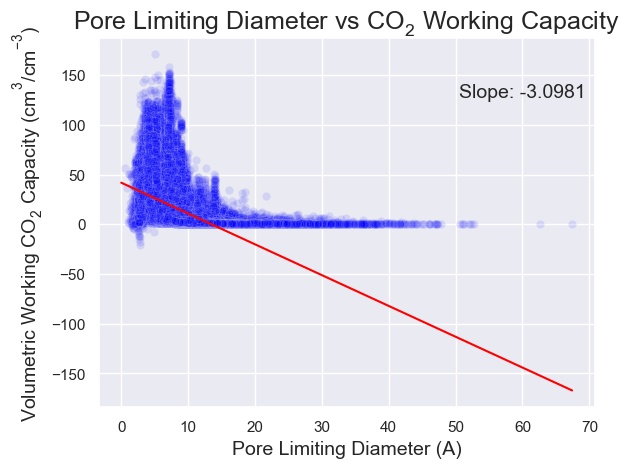

In [24]:
correlate('pore_limiting_diameter', 'Pore Limiting Diameter (A)', 'Pore Limiting Diameter vs $CO_2$ Working Capacity')

In [21]:
data['pld_log'] = np.log(data['pore_limiting_diameter'])

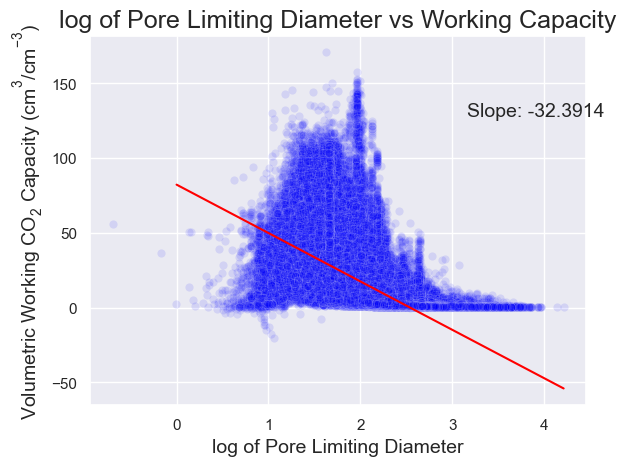

In [23]:
correlate('pld_log', 'log of Pore Limiting Diameter', 'log of Pore Limiting Diameter vs Working Capacity')

Very interesting! So we're seeing some trends already. While surface area has almost no correlation at all with working capacity, the density, pore limiting diameter, and largest cavity diameters are all telling us that smaller pores/openings and a more tightly packed framework is giving us slightly better working capacity. 

In [25]:
def rdf_corr(rdf_feature):
    
    # Make empty dataframe for correlation values and column list for columns of interest
    df = pd.DataFrame()
    cols = []
    
    # Loop through all columns in the data and list those for the RDF of interest
    for col in data.columns:
        if rdf_feature in col:
            cols.append(col)
    
    # Loop through RDF columns and identify those that are normally distributed with p-values below 0.05
    for column in tqdm(cols):
        s_test, alpha = scipy.stats.shapiro(data[col])
        if s_test > 0.05 and alpha < 0.05:
            
            # Calculate Pearson correlation coefficients for each normally distributed column
            reduced = data.dropna(subset = column)
            p_test, alpha2 = scipy.stats.pearsonr(reduced[column], reduced['v/v_working_capacity'])
            
            # If Pearson correlation coefficient has p-value below 0.05 add a row to the dataframe with that data
            if alpha2 < 0.05:                
                new_row = pd.DataFrame([{'feature': rdf_feature, 'rdf_distance': column.split('_')[2], 'correlation': p_test}])
                df = pd.concat([df, new_row])
    df = df.astype({'feature':'object', 'rdf_distance':'float64', 'correlation':'float64'})            
    return df

In [26]:
rdf_feats = ['electronegativity', 'hardness', 'vdWaalsVolume', 'polarizability', 'mass', 'none']

In [27]:
import warnings

warnings.filterwarnings("ignore", category=UserWarning)

In [28]:
rdf_en = rdf_corr('electronegativity')

100%|████████████████████████████████████████████████████████████████████████████████| 113/113 [01:21<00:00,  1.38it/s]


In [29]:
type(rdf_en)

pandas.core.frame.DataFrame

In [30]:
rdf_en.head()

,feature,rdf_distance,correlation
0,electronegativity,2.000,0.324885
0,electronegativity,2.004,0.327822
0,electronegativity,2.013,0.333542
0,electronegativity,2.027,0.341698
0,electronegativity,2.044,0.351677


In [31]:
rdf_hard = rdf_corr('hardness')

100%|████████████████████████████████████████████████████████████████████████████████| 113/113 [01:31<00:00,  1.23it/s]


In [32]:
rdf_vdwv = rdf_corr('vdWaalsVolume')

100%|████████████████████████████████████████████████████████████████████████████████| 113/113 [01:15<00:00,  1.50it/s]


In [33]:
rdf_pol = rdf_corr('polarizability')

100%|████████████████████████████████████████████████████████████████████████████████| 113/113 [01:15<00:00,  1.49it/s]


In [34]:
rdf_mass = rdf_corr('mass')

100%|████████████████████████████████████████████████████████████████████████████████| 113/113 [01:16<00:00,  1.49it/s]


In [35]:
rdf_none = rdf_corr('none')

100%|████████████████████████████████████████████████████████████████████████████████| 113/113 [01:17<00:00,  1.47it/s]


In [36]:
rdf_all = pd.concat([rdf_en, rdf_hard, rdf_vdwv, rdf_pol, rdf_mass, rdf_none])

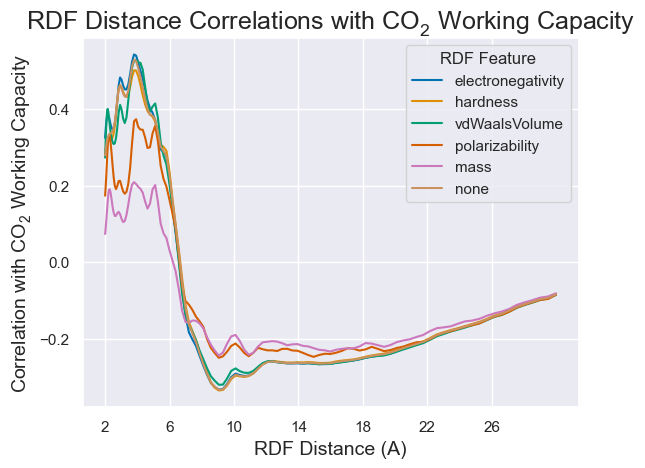

In [37]:
sns.lineplot(data = rdf_all, x = 'rdf_distance', y = 'correlation', hue = 'feature', palette = 'colorblind')
plt.xlabel('RDF Distance (A)', fontsize = 14)
plt.xticks(np.arange(2, 30, 4.0))
plt.ylabel('Correlation with $CO_2$ Working Capacity', fontsize = 14)
plt.title('RDF Distance Correlations with $CO_2$ Working Capacity', fontsize = 18)
plt.legend(title='RDF Feature')
plt.savefig('../figures/rdf_correlations.png',dpi=1200, bbox_inches='tight')
plt.show()

Very interesting, so there are positive correlations between each of these RDF features between 2 and 6-7 A, but those turn negative beyond that distance. Let's identify those maxima and minima for each RDF feature.

In [38]:
rdf_all.sort_values('correlation', ascending = False).drop_duplicates(['feature'], keep='first')

,feature,rdf_distance,correlation
0,electronegativity,3.797,0.542426
0,none,3.797,0.528685
0,vdWaalsVolume,3.925,0.527383
0,hardness,3.797,0.500823
0,polarizability,3.925,0.373447
0,mass,3.797,0.209035


In [39]:
rdf_all.sort_values('correlation', ascending = False).drop_duplicates(['feature'], keep='last')

,feature,rdf_distance,correlation
0,mass,9.062,-0.243812
0,polarizability,9.062,-0.249429
0,vdWaalsVolume,9.062,-0.319816
0,electronegativity,9.062,-0.332715
0,none,9.062,-0.332866
0,hardness,9.062,-0.334719


Great! Now I know that when I'm trimming features later on I'll likely keep RDFs at distances of around 3.8-3.9 and 9.062.

Now I want to take a look at the topologies of the MOFs and see if there are any that really stand out as ideal for this problem.

In [40]:
data['likely topology'].nunique()

483

There are a lot of topologies included here, so I want to get a quick look at how the average working capacity for each topology is distributed. If there are a few top performers I can look to single those out as preferred topologies.

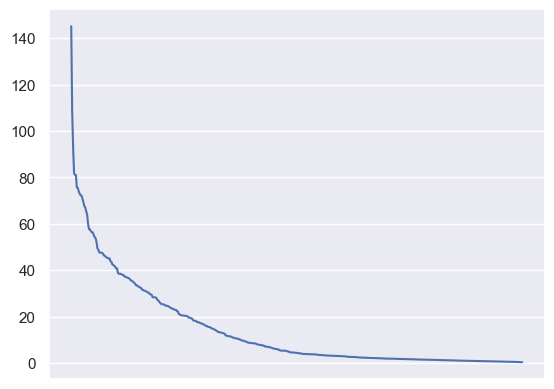

In [41]:
plt.plot(data.groupby('likely topology')['v/v_working_capacity'].mean().sort_values(ascending=False))
plt.xticks([])
plt.show()

Ok, so there are a few topologies that perform much better than the vast majority. Since I'm interested in generalizing topologies I'll limit my results to only those with more than 20 entries and I'll make boxplots of the top 10 of those to get a feel for their distributions.

In [42]:
# Create a list of all topologies with more than 20 entries
top20 = []
for topology in data['likely topology'].unique():
    if data['likely topology'].value_counts()[topology] > 20:
        top20.append(topology)

In [43]:
# Subset the data to only the topologies with more than 20 entries
top = data[data['likely topology'].isin(top20)]

In [44]:
# Calculate the average working capacity of the topologies with more than 20 entries
top_top = top.groupby('likely topology')['v/v_working_capacity'].mean().sort_values(ascending=False)[0:10]

In [45]:
# Subset the data to only the top 10 topologies with more than 20 entries
top10 = data[data['likely topology'].isin(top_top.index)]

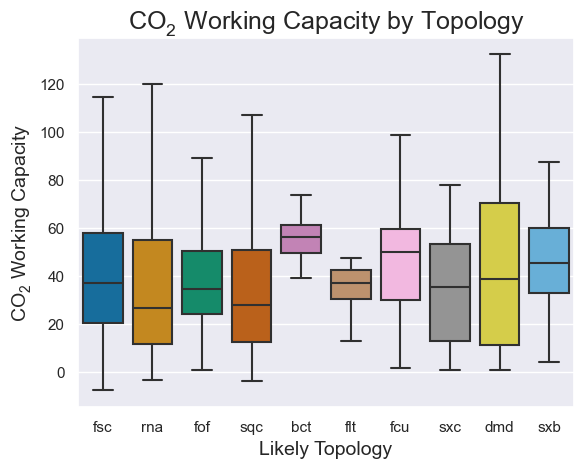

In [46]:
sns.boxplot(x='likely topology', y='v/v_working_capacity', data=top10, palette='colorblind', showfliers=False)
plt.title('$CO_2$ Working Capacity by Topology', fontsize=18)
plt.xlabel('Likely Topology', fontsize=14)
plt.ylabel('$CO_2$ Working Capacity', fontsize=14)
plt.savefig('../figures/topology.png', dpi=1200, bbox_inches='tight')
plt.show()

Most of these have huge ranges, which doesn't really show much of a trend, but bct is at least a much tighter range that has a higher floor and higher average than the rest. 

To quickly explore correlations between the various features and the volumetric CO2 capacity I'm going to create a loop similar to the one I used for RDFs, except this one will screen out RDFs and categorical features, calculate a Pearson correlation coefficient, then I'll do a quick plot of descending correlations to get a feel for how many are worth digging into deeper.

In [47]:
def non_rdf_corr(dataframe):
    
    # Make empty dataframe for correlation values and column list for columns of interest
    df = pd.DataFrame()
    cols = []
    
    # Loop through all columns in the data and list those that are numeric and aren't RDFs
    for col in data.columns:
        if 'RDF' not in col:
            if dataframe[col].dtypes in ['float64', 'int64']:
                cols.append(col)
    
    # Loop through columns and identify those that are normally distributed with p-values below 0.05
    for column in tqdm(cols):
        s_test, alpha = scipy.stats.shapiro(data[col])
        if s_test > 0.05 and alpha < 0.05:
            
            # Calculate Pearson correlation coefficients for each normally distributed column
            reduced = data.dropna(subset = column)
            p_test, alpha2 = scipy.stats.pearsonr(reduced[column], reduced['v/v_working_capacity'])
            
            # If Pearson correlation coefficient has p-value below 0.05 add a row to the dataframe with that data
            if alpha2 < 0.05:                
                new_row = pd.DataFrame([{'feature': column, 'correlation': p_test}])
                df = pd.concat([df, new_row])
    df = df.astype({'feature':'object', 'correlation':'float64'})            
    return df

In [48]:
non_rdf_corrs = non_rdf_corr(data)

 29%|███████████████████████▍                                                         | 62/214 [00:56<01:39,  1.53it/s]C:\Users\zbro1\anaconda\envs\MOF\lib\site-packages\scipy\stats\_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
 35%|████████████████████████████                                                     | 74/214 [01:05<01:33,  1.50it/s]C:\Users\zbro1\anaconda\envs\MOF\lib\site-packages\scipy\stats\_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
 36%|█████████████████████████████▌                                                   | 78/214 [01:07<01:27,  1.55it/s]C:\Users\zbro1\anaconda\envs\MOF\lib\site-packages\scipy\stats\_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(s

 92%|█████████████████████████████████████████████████████████████████████████▋      | 197/214 [02:27<00:11,  1.53it/s]C:\Users\zbro1\anaconda\envs\MOF\lib\site-packages\scipy\stats\_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
 93%|██████████████████████████████████████████████████████████████████████████      | 198/214 [02:28<00:10,  1.47it/s]C:\Users\zbro1\anaconda\envs\MOF\lib\site-packages\scipy\stats\_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
 94%|███████████████████████████████████████████████████████████████████████████▌    | 202/214 [02:30<00:07,  1.53it/s]C:\Users\zbro1\anaconda\envs\MOF\lib\site-packages\scipy\stats\_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(s

The constant input warning above makes it clear that I have some columns that need to be dropped. Let's identify them and then drop them.

In [49]:
constants = []
for col in data.columns:
    if data[col].nunique() == 1:
        constants.append(col)

constants

['mc-I-0-all',
 'D_mc-chi-0-all',
 'D_mc-Z-0-all',
 'D_mc-I-0-all',
 'D_mc-I-1-all',
 'D_mc-I-2-all',
 'D_mc-I-3-all',
 'D_mc-T-0-all',
 'D_mc-S-0-all',
 'lc-I-0-all',
 'D_lc-chi-0-all',
 'D_lc-Z-0-all',
 'D_lc-I-0-all',
 'D_lc-I-1-all',
 'D_lc-I-2-all',
 'D_lc-I-3-all',
 'D_lc-T-0-all',
 'D_lc-S-0-all',
 'D_lc-alpha-0-all',
 'D_func-chi-0-all',
 'D_func-Z-0-all',
 'D_func-I-0-all',
 'D_func-I-1-all',
 'D_func-I-2-all',
 'D_func-I-3-all',
 'D_func-T-0-all',
 'D_func-S-0-all',
 'D_func-alpha-0-all']

These are all revised autocorrelation function descriptors (RACs), which are products or differences in electronic properties computed on a non-weighted chemical graph. The RACs calculated are electronegativity, nuclear charge, atom identity, connectivity, and covalent radii. Polarizability is also included for the linker-connecting atom.

To understand each feature, some abbreviations need to be spelled out:
* mc = metal center
* f-lig = ligand
* func = functional group
* lc = linker connecting
* If the name is prefixed with a D_ then the RAC is a difference calculation, otherwise it's a product
* chi = Pauling electronegativity
* Z = nuclear charge
* T = connectivity
* I = atom identity
* S = covalent radius
* alpha = polarizability
* The number at the end indicates the depth of the calculation, maxing out at 3

To better understand these features I'll explain some of the basic concepts here. 
* A ligand refers to the organic molecule that is used in a MOF to connect the metal centers
* Functional groups are special groups of atoms that impart some special properties such as chemical reactivity, a polar site to attract other molecules, etc
* Electronegativity refers to how strongly the nucleus of an atom pulls the electrons towards itself
* Polarizability refers to how easily an atom or molecule can have its electrons moved to create temporary polarity

I think it's important to spell this out prior to dropping them so we know what's being removed.

In [50]:
data.drop(columns = constants, inplace = True)

Now let's get back to plotting those correlation coefficients.

In [51]:
non_rdf_corrs = non_rdf_corr(data)

100%|████████████████████████████████████████████████████████████████████████████████| 186/186 [02:01<00:00,  1.53it/s]


In [52]:
non_rdf_corrs['correlation'].sort_values(ascending=False).head()

0    1.000000
0    0.976459
0    0.969289
0    0.969289
0    0.966155
Name: correlation, dtype: float64

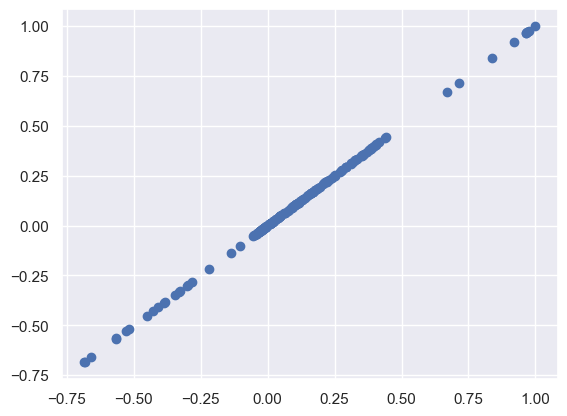

In [53]:
plt.scatter(non_rdf_corrs['correlation'].sort_values(ascending=False), non_rdf_corrs['correlation'].sort_values(ascending=False))
plt.show()

Great, there are gaps around -0.5 and 0.5, so I can set cutoffs there and get a quick list of only the properties less than -0.5 or greater than 0.5 to see what the key drivers are.

In [54]:
non_rdf_corrs['feature'].unique()

array(['unit_cell_volume', 'Density', 'accessible_surface_area',
       'volumetric_surface_area', 'gravimetric_surface_area',
       'inaccessible_surface_area', 'inac_grav_surf_area',
       'inac_vol_surf_area', 'accessible_volume_per_uc',
       'volume_fraction', 'grav_volume', 'inac_vol', 'inac_vol_frac',
       'inac_grav_vol', 'probe_occupiable_vol', 'probe_occ_vol_frac',
       'grav_probe_occ_vol', 'inac_probe_occ_vol',
       'inac_probe_occ_vol_frac', 'inac_probe_occ_grav_vol',
       'largest_cav_diameter', 'pore_limiting_diameter',
       'largest_free_sphere_path_diam', 'mmol/g_uptake',
       'mmol/g_working_capacity', 'v/v_uptake', 'v/v_working_capacity',
       'wt%_uptake', 'wt%_working_capacity', 'selectivity', 'purity',
       'sorbent_selection_parameter', 'adsorption_fig_of_merit',
       'f-chi-0-all', 'f-chi-1-all', 'f-chi-2-all', 'f-chi-3-all',
       'f-Z-0-all', 'f-Z-1-all', 'f-Z-2-all', 'f-Z-3-all', 'f-I-0-all',
       'f-I-1-all', 'f-I-2-all', 'f-I-3-all',

In [55]:
most_significant = pd.DataFrame()

for f in non_rdf_corrs['feature'].unique():
    if f != 'v/v_working_capacity':
        if abs(non_rdf_corrs.loc[non_rdf_corrs['feature'] == f, 'correlation'].iloc[0]) > 0.5:
            new_row = pd.DataFrame([{'feature' : f, 'correlation' : non_rdf_corrs.loc[non_rdf_corrs['feature'] == f,\
                                                                                      'correlation'].iloc[0]}])
            most_significant = pd.concat([most_significant, new_row])

In [56]:
most_significant.set_index('feature', inplace = True)

In [57]:
most_significant.sort_values(by = 'correlation', ascending=False)

,correlation
feature,
v/v_uptake,0.976459
wt%_working_capacity,0.969289
mmol/g_working_capacity,0.969289
wt%_uptake,0.966155
mmol/g_uptake,0.966155
selectivity,0.919536
adsorption_fig_of_merit,0.837182
Density,0.715998
purity,0.669020


It's good that I took a look at this, because I'm noticing some features here that are almost perfect predictors of the volumetric working capacity which are just other measures of working capacity. Since they won't be used as my metric I should throw out 'v/v_uptake', 'wt\%_working_capacity', 'mmol/g_working_capacity', 'wt\%_uptake', and 'mmol/g_uptake'. It's also important to recognize that adsorption figure of merit, purity, sorbent selection parameter, and selectivity are consequences of the MOF construction, with adsorption figure of merit being a measure of how good the MOF is in a situation, and selectivity/purity being measures of preference for CO2 over water. Since these are not things that can be controlled up front when designing a MOF, I will remove them from the dataset as well since they're essentially creating data leakage.

In [58]:
data.drop(columns = ['v/v_uptake', 'wt%_working_capacity', 'mmol/g_working_capacity', 'wt%_uptake', 'mmol/g_uptake',\
                     'selectivity', 'sorbent_selection_parameter', 'adsorption_fig_of_merit', 'purity'], inplace = True)

Ok, we've explored most of the features and have an idea of what to expect going into modeling. Let's save the dataset and move on to preprocessing.

In [59]:
data.to_csv('../data/interim/eda.csv')